Note: Throughout this notebook, you are **not obliged to** fill any function. Provided function headers or codes aim to help you to find a way to the solution. You are free to delete them if that helps.

In [236]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
import scipy as sc
import pandas as pd
import itertools

# Question: Linear Regression

Suppose we are given the following model 
$$
y_i \approx m x_i + \sum_{k=1}^K a_k \sin(\omega_k x_i) + \sum_{i=1}^K b_k \cos(\omega_k x_i)
$$

Show that this problem can be reduced to a least squares problem of form
$$
y \approx A(\omega, K) \theta
$$
where the design matrix $A(\omega, K)$ is determined solely by the frquency parameters $\omega$ and the remaining parameters can be organized as a vector $\theta = (m, a_{1:K}, b_{1:K})$. 


## Write a program that generates data from the above model

In [237]:
def make_design_matrix(x, om):
    #A = []
    
    # This part converts x into a column vector
    try:
        vectorized_x = x.reshape((x.shape[0],1))
    except IndexError:
        # the case where x is a scalar
        vectorized_x = x.reshape((1,1))
    
    # This part calculates dot product of x and w
    try:
        wx = vectorized_x.dot(om.reshape((om.shape[0],1)).T)
    except IndexError:
        #the case where om is a scalar, i.e K=1
        wx = om*vectorized_x
        
    sinwx = np.sin(wx)
    coswx = np.cos(wx)

    # Generating the design matrix A
    temp = np.concatenate((vectorized_x, sinwx), axis=1)
    A = np.concatenate((temp, coswx), axis=1)

    return A

#### VECTORIZED NEW VERSION
# Find y values vectorized form
def find_y(x,om,m,a,b,noise=False):
    A = make_design_matrix(x, om)
    theta = np.append(m, [a, b])
    theta = theta.reshape((theta.shape[0],1))
    y = A.dot(theta)
    y = y.reshape((y.shape[0],))
    if noise:
        y = y + 0.5*np.random.randn(y.shape[0])
    
    return y

In [238]:
K = 4
N = 50
#A will be (N by (1 + 2K)) matrix
A = []
m   = [np.random.randn()]
a_s = np.random.uniform(low=-10, high=10, size=(K,))   # K vector
b_s = np.random.uniform(low=-10, high=10, size=(K,))   # K vector
w_s = np.random.uniform(low=0,   high=12, size=(K,))   # K vector
x_s = np.random.uniform(low=-1,  high=1,  size=(N,))   # N vector
y_s = []


A  = make_design_matrix(x_s, w_s)
y_s = find_y(x_s, w_s, m, a_s, b_s, noise=True)

In [239]:
print(a_s)

[ 5.00696017  4.53725796 -2.11984292 -5.27080596]


In [240]:
print(b_s)

[-6.44879617 -3.71234123  3.61429361 -2.81790063]


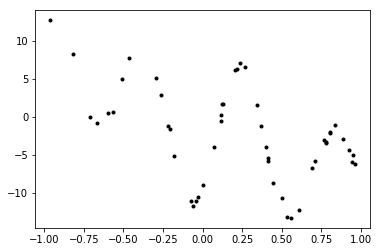

In [241]:
plt.figure()
plt.plot(x_s, y_s, 'k.')
plt.show()

In [242]:
# This data is generated for K=4,N=50,m=0.2. It is distorted with a noise as well. You may try to obtain a similar plot or
# generate a different one.

## For a given set of frequency parameters $\omega$ solve the problem using least squares

In this experiment, we will assume that we know the frequency parameters $\omega$ (hence also the dimension $K$). Write a program to find the least squares solution of $\theta$.

### Some useful functions

In [244]:
def find_theta(A,y_s):
    return inv((A.T.dot(A))).dot(A.T).dot(y_s)

def find_predicted_ys(pred_A,pred_theta):
    return pred_A.dot(pred_theta)

def find_error(y_s,fake_ys):
    return np.sum(np.square(y_s - fake_ys))

## Evaluate and visualize the error as a function of $\omega$ only

This error can be fully visualized for $K=1$ and $K=2$.

Note that for any given $\omega$ we could run the least squares algorithm to find the best $m, \alpha, \beta$ parameters. We will denote the optimal parameters as $\theta^*(\omega) = (m, a, b)^*$. We will exhaustively evaluate the error for all $\omega$ by computing $E(\omega, \theta^*(\omega))$.

# Error for K=1

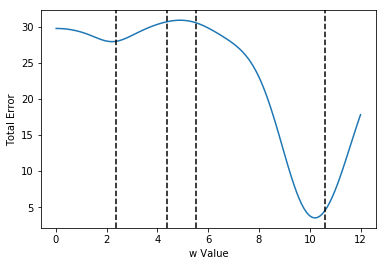

The minimum error is:  3.5119050641001452


In [245]:
ws_1D = np.linspace(0.01, 12.0, num=120)
errors_1D = []

# Find all errors
for w in ws_1D:
    cur_A       = make_design_matrix(x_s, w)
    cur_theta   = find_theta(cur_A, y_s)
    cur_pred_ys = find_predicted_ys(cur_A,cur_theta)
    cur_error   = find_error(y_s,cur_pred_ys)
    errors_1D.append(cur_error/N)

plt.figure()
plt.plot(ws_1D, errors_1D, '-')
plt.xlabel('w Value')
plt.ylabel('Total Error')
for w in w_s:
    plt.axvline(x=w,linestyle='--',color='black') 
plt.show()

print('The minimum error is: ',np.amin(errors_1D))

# Error for K=2

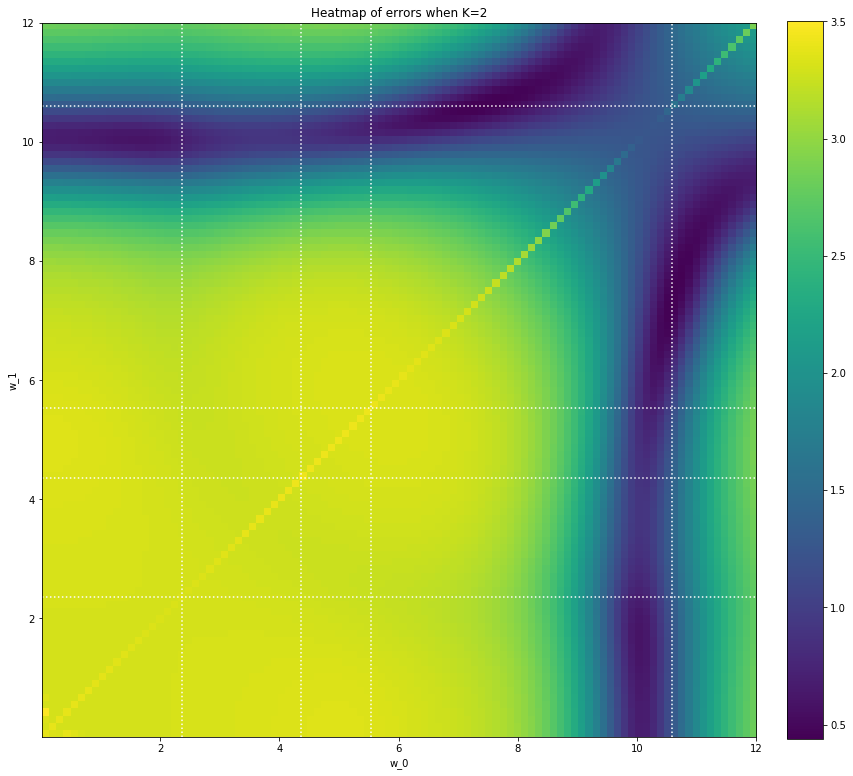

In [246]:
#%matplotlib inline
MAX_OM = 12
OM = np.linspace(0.01,MAX_OM,100)
EE = np.zeros((len(OM),len(OM)))
for i,omega1 in enumerate(OM):
    for j,omega2 in enumerate(OM):
        # Compute the errors for different omega combinations. Do not forget to consider rank defficient design matrix case.
        if omega1 == omega2:
            cur_A       = make_design_matrix(x_s, omega1)
        else:
            cur_A       = make_design_matrix(x_s, np.array([omega1,omega2]))
        cur_theta   = find_theta(cur_A, y_s)
        cur_pred_ys = find_predicted_ys(cur_A,cur_theta)
        cur_error   = find_error(y_s,cur_pred_ys)
        EE[i,j] = cur_error/N

# These lines are for plotting purposes
l = min(OM)
r = max(OM)
plt.figure(figsize=(14,14))
im = plt.imshow(np.log(EE), extent=(l,r,l,r), interpolation='nearest', origin='lower')
for o in om_true:
    plt.axvline(o, color='w',ls=':')
    plt.axhline(o, color='w',ls=':')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xlabel('w_0')
plt.ylabel('w_1')
plt.title('Heatmap of errors when K=2')
plt.show()

# Question: Stochastic Gradient Descent

For the sinusoidal model, develop a SGD method for estimating $\omega$ as well as the other parameters.

## Derive and implement the expression of the gradient

$$
E_i(m,a,b,\omega) = \frac{1}{2}\left(y_i - \left(m x_i + \sum_{k=1}^K a_k \sin(\omega_k x_i) + \sum_{k=1}^K b_k \cos(\omega_k x_i)\right)\right)^2
$$

$$
e_i = y_i - \left(m x_i + \sum_{k=1}^K a_k \sin(\omega_k x_i) + \sum_{k=1}^K b_k \cos(\omega_k x_i)\right)
$$

\begin{eqnarray}
\nabla E_i = \left(\begin{array}{c} \frac{\partial E_i}{\partial m} \\ \frac{\partial E_i}{\partial a_1} \\
\vdots \\ \frac{\partial E_i}{\partial a_K} \\  \frac{\partial E_i}{\partial b_1} \\
\vdots \\ \frac{\partial E_i}{\partial b_K} \\  \frac{\partial E_i}{\partial \omega_1} \\
\vdots \\ \frac{\partial E_i}{\partial \omega_K} 
\end{array}
\right) = 
-e_i \left(\begin{array}{c} x_i \\ \sin(\omega_1 x_i) \\ \vdots \\ \sin(\omega_K x_i) \\ 
\cos(\omega_1 x_i) \\ \vdots \\ \cos(\omega_K x_i) \\ a_1 \cos(\omega_k x_i) x_i - b_1 \sin(\omega_1 x_i) x_i \\
\vdots \\ a_K \cos(\omega_K x_i) x_i - b_K \sin(\omega_K x_i) x_i\end{array}
\right)
\end{eqnarray}

In [247]:
# You can fill this function to genrerate the actual model.
def model_fun(X, theta, omegas):
    Y = find_y(X,omegas,theta[0],theta[1:len(omegas)+1],theta[len(omegas)+1:])
    return Y


# You can fill this funtion to compute gradients of the parameters
def grad_fun(y, x, theta, omegas):
    m = theta[0]
    a_s = theta[1:len(omegas)+1]
    b_s = theta[len(omegas)+1:]
    
    e_i = y - find_y(x, omegas, m, a_s, b_s)
    
    gradient = np.array(x)
    sins = np.sin(np.multiply(omegas,x))
    coss = np.cos(np.multiply(omegas,x))
    
    vec_a = np.multiply(a_s*coss,x)
    vec_b = np.multiply(b_s*sins,x)
    
    gradient = np.append(gradient, [sins, coss, vec_a-vec_b])
    
    return np.multiply(-e_i,gradient)

#TEST PURPOSE BELOW
K_try = 2
om = np.random.rand(K_try)*4*np.pi
th = np.random.randn(len(om)*2+1)
#grad_fun([7,2],[3,4],th,om)

## Implement SGD

Implement SGD and test it on synthetic data generated in Question 1. 
Show the evolution of the error as a function of iterations.


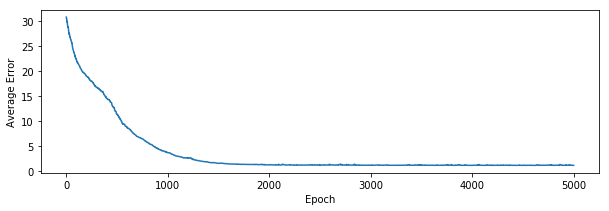

In [257]:
#%matplotlib inline

K_try = 2
# Initialize
ep = 0.005
om = np.random.rand(K_try)*4*np.pi
th = np.random.randn(len(om)*2+1)

batch_size = 1

ERR = []
OM_PATH = [om]

MAX_EPOCH = 5000
for epoch in range(MAX_EPOCH):
    # Implement SGD here
    indexes = np.random.randint(0,N,batch_size)
    x_batch = x_s[indexes]
    y_batch = y_s[indexes]
    
    grad_batch = np.zeros(3*K_try+1)
    for i in range(batch_size):
        grad_batch += grad_fun(y_batch[i], x_batch[i], th, om)
    grad_avg = grad_batch/batch_size
    
    # Update
    th = th - ep*grad_avg[:2*K_try+1]
    om = om - ep*grad_avg[2*K_try+1:]
    
    E = 0
    y_head = find_y(x_s, om, th[0], th[1:K_try+1], th[K_try+1:])
    
    E = 0.5*np.sum(np.square(y_head-y_s))
    
    ERR.append(E/N)
    OM_PATH.append(om)
    
# PLot the error as a function of iteratation
plt.figure(figsize=(10,3))
plt.plot(ERR)
plt.xlabel('Epoch')
plt.ylabel('Average Error')
plt.show()

## Plot the true function and the fit

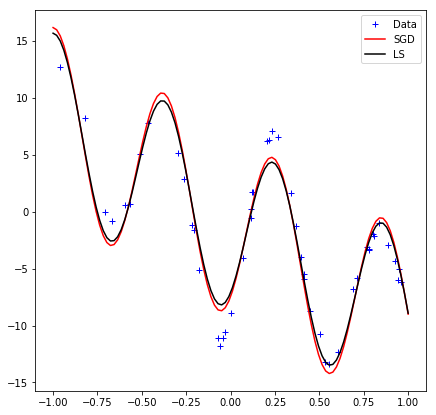

In [258]:
xs_uniform  = np.linspace(-1.0, 1.0, num=100)
#ys_uniform  = [find_y(x) for x in xs_uniform]
ys_uniform = find_y(xs_uniform,w_s,m,a_s,b_s)

ys_SGD = model_fun(xs_uniform,th,om)

cur_A       = make_design_matrix(xs_uniform, om)
cur_theta   = find_theta(cur_A, ys_uniform)
ys_LS = find_predicted_ys(cur_A,cur_theta)

plt.figure(figsize=(7,7))
plt.plot(x_s, y_s, 'k+',color='blue')
plt.plot(xs_uniform, ys_SGD, '-',color='red')
plt.plot(xs_uniform, ys_LS, '-',color='black')
plt.legend(['Data','SGD','LS'])

plt.show()

## Plot the error surface and plot the path taken by SGD

[[ 7.41844526  5.7102082 ]
 [ 7.4070347   5.70828709]
 [ 7.44495701  5.70397252]
 ...
 [10.22256295  0.76890476]
 [10.22399016  0.76193417]
 [10.20838336  0.76869948]]


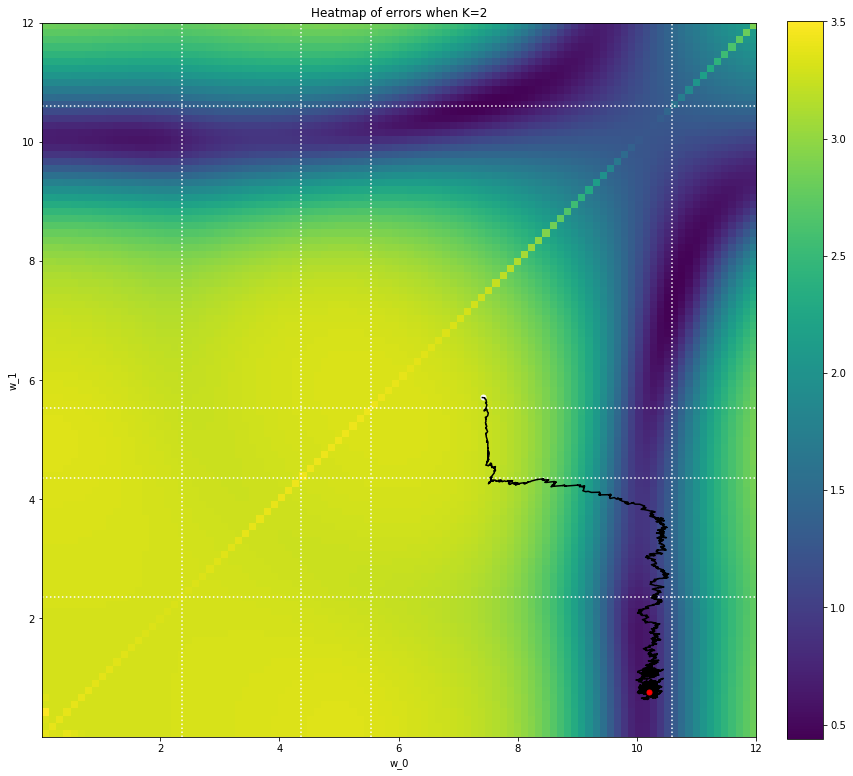

In [259]:
%matplotlib inline
l = min(OM)
r = max(OM)
plt.figure(figsize=(14,14))
im = plt.imshow(np.log(EE), extent=(l,r,l,r), interpolation='nearest', origin='lower')
for o in om_true:
    plt.axvline(o, color='w',ls=':')
    plt.axhline(o, color='w',ls=':')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xlabel('w_0')
plt.ylabel('w_1')
plt.title('Heatmap of errors when K=2')
om_path = np.array(OM_PATH)
print(om_path)
plt.plot(om_path[0,0],om_path[0,1], 'w.', markersize=10) 
plt.plot(om_path[1:-1,0],om_path[1:-1,1], color='black') 
plt.plot(om_path[-1,0],om_path[-1,1], 'r.', markersize=10) 
plt.show()

In [253]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import pandas as pd

from sklearn.datasets import load_iris

# Question 3: Decision Trees

In this exercise we will investigate and compare two alternative measures for choosing a 
decision boundary and a feature in decision trees: (a) Gini impurity and (b) Information Gain. 

Suppose there are $C$ classes in a dataset with $N$ samples. The number of examples having class $c$ is
$N_c$ where $\sum_c N_c = N$. 

At each step, a decision tree algorithm tries multiple potential thresholds (remember that as the basic decision tree algorithm looks at a single feature at a time
we only need to consider midpoints) and selects the one that would lead to the "purest" partitions. We will measure 
the impurity by Entropy or the Gini impurity.


A given threshold $\tau$ subdivides the dataset into two partitions of sizes $L$ and $R$
according to a single feature $x$: $L$ data points with $x< \tau$ and $R$ data points with $x \geq \tau$ where $L + R = N$. The number of data points of class $c$ in each partition is $L_c$ and $R_c$. We have $L_1 + L_2 + \dots + L_C = L$ and $R_1 + R_2 + \dots + R_C = R$.

The Gini impurity is defined as:
$$G(p_{1:C}) = 1 - \Sigma_c p_c^2$$
where $p_i$ is the frequency of each class

The entropy, on the other hand is defined as 
$$H(p_{1:C}) =  - \Sigma_c p_c \log{p_c}$$
Note that $\log$ stands for the natural logarithm.

Compute the following indices

### Gini:
$$
U_G(\tau) = \frac{L}{N} G(L_{1:C}/L) + \frac{R}{N} G(R_{1:C}/R)
$$
### Entropy:
$$
U_H(\tau) = \frac{L}{N} H(L_{1:C}/L) + \frac{R}{N} H(R_{1:C}/R)
$$

### Information gain:
$$
I(\tau) = H(N_{1:C}/N) - U_H(\tau)
$$


Given a dataset write a program that plots the scatterplot any two features and computes each index.


In [14]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import pandas as pd
from sklearn.datasets import load_iris

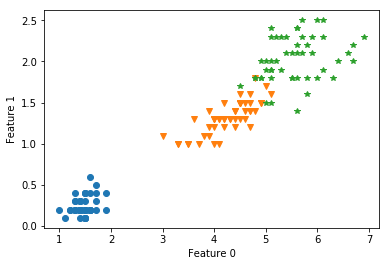

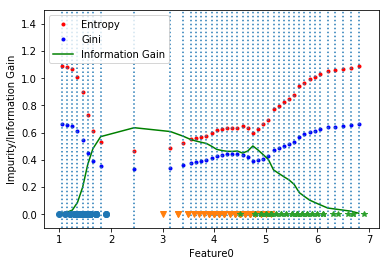

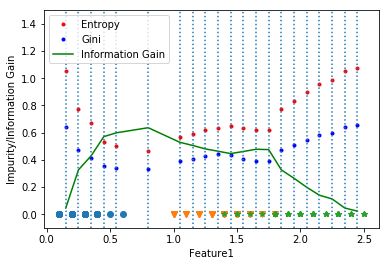

In [15]:
dataset = load_iris()
X, c = dataset['data'][:,2:], dataset['target']
M, N = X.shape


class_labels = np.unique(c)
num_of_labels = len(class_labels)

col = 'ov*'

for z in range(num_of_labels):
    ss = c == z
    plt.plot(X[ss,0], X[ss,1],col[z])
    
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.show()


for idx in range(N):
    ux = np.unique(X[:,idx])
    boundries = np.convolve(ux, np.array([0.5, 0.5]), mode='valid')

    G = np.zeros_like(boundries)
    H = np.zeros_like(boundries)
    IG = np.zeros_like(boundries)

    for i, tau in enumerate(boundries):    
        u, cnt = np.unique(c, return_counts=True)
        u_l, cnt_l = np.unique(c[X[:,idx]<=tau], return_counts=True)
        u_r, cnt_r = np.unique(c[X[:,idx]>tau], return_counts=True)

        #p_l = np.zeros(num_of_labels)
        #p_l[u_l] = cnt_l/np.sum(cnt_l)
        p_l = cnt_l/np.sum(cnt_l)
        w_l = np.sum(cnt_l)/np.sum(cnt)
    
        #p_r = np.zeros(num_of_labels)
        #p_r[u_r] = cnt_r/np.sum(cnt_r)
        p_r = cnt_r/np.sum(cnt_r)
        w_r = np.sum(cnt_r)/np.sum(cnt)

        p = cnt/np.sum(cnt)
        
        G[i] = w_l*(1 - np.sum(p_l**2) ) + w_r*(1 - np.sum(p_r**2) )
        H[i] = -w_l*np.sum(p_l*np.log(p_l)) - w_r*np.sum(p_r*np.log(p_r))
        IG[i] = -np.sum(p*np.log(p)) - (-w_l*np.sum(p_l*np.log(p_l)) - w_r*np.sum(p_r*np.log(p_r)))
        
        #print('L:', u_l, cnt_l)
        #print('R:', u_r, cnt_r)

    plt.plot(boundries, H, '.r')
    plt.plot(boundries, G, '.b')
    plt.plot(boundries, IG, 'g')
    plt.ylim([-0.1,1.5])


    plt.xlabel('Feature'+str(idx))
    plt.ylabel('Impurity/Information Gain')
    plt.legend(['Entropy','Gini', 'Information Gain'])
    for b in boundries:
        plt.axvline(b, ls=':')
        
    for z in range(num_of_labels):
        ss = c == z
        plt.plot(X[ss,idx], np.zeros_like(X[ss,idx]),col[z])

    plt.show()

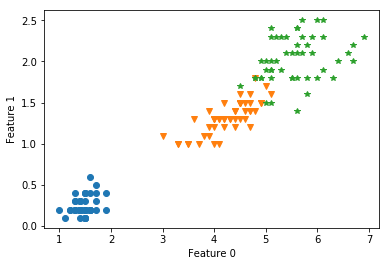

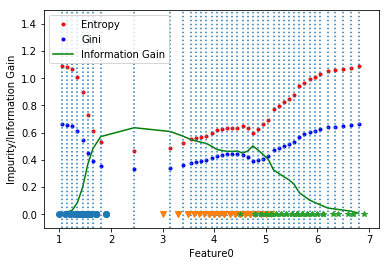

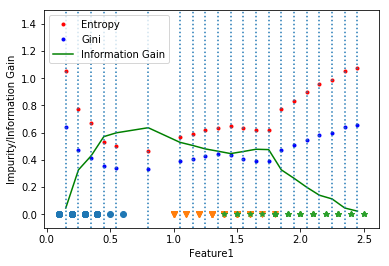

# Question 4: ROC curve and the AUC score

Suppose you are given two probability distributions, each denoting a class conditional density of a feature.

Sample from the distributions and estimate the ROC curve and the AUC (area under the curve) score.

The densities should be 

1. Gaussians with mean $\mu_0$ and variance $V_0$ $\mathcal{N}(\mu_0, V_0)$ and $\mu_1$ and variance $V_1$
1. Symmetric triangular distribution on the inteval $(a_0, b_0)$ and $(a_1, b_1)$

Note that your code should work for any variance and mean value. 
Here are example plots for $\mathcal{N}(0,0.5)$ and $\mathcal{N}(1,0.1)$

In [106]:
from sklearn.metrics import roc_curve, auc

def generate_gaussian(mu,var,sample_size=1000):
    return np.random.normal(mu,var,sample_size)

def generate_triangular(a,b,sample_size=1000):
    peak = (a+b)/2
    return np.random.triangular(a,peak,b,sample_size)


def generate_roc(dist0,dist1,roc_class):
    all_data = np.concatenate([dist0,dist1])
    all_data = np.vstack((all_data, np.concatenate([np.zeros(len(dist0)), np.ones(len(dist1))])))
    all_data = all_data.T
    all_data = all_data[np.argsort(all_data[:,0])] 

    thresholds = np.linspace(np.amin(all_data),np.amax(all_data),100)
    
    tps = []
    fps = []
    for threshold in thresholds:
        temp = all_data[all_data[:,0]<=threshold]
        one_count = np.count_nonzero(temp[:,1])
        zero_count = len(temp)-one_count
        
        if roc_class==0:
            tp = zero_count/1000
            fp = one_count/1000
        else:
            tp = one_count/1000
            fp = zero_count/1000

        tps.append(tp)
        fps.append(fp)
        
        
    return fps,tps
    
mu0, var0 = 0, 0.5
mu1, var1 = 1, 0.1
a0, b0    = 3, 12
a1, b1    = 9, 20

gaussian0 = generate_gaussian(mu0,var0)
gaussian1 = generate_gaussian(mu1,var1)

triangular0   = generate_triangular(a0,b0)
triangular1   = generate_triangular(a1,b1)

fps, tps = generate_roc(triangular0, triangular1, 0)

AUC score = 0.995533


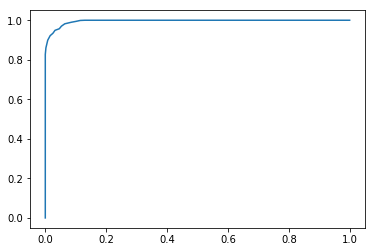

In [107]:
print("AUC score =" , auc(fps,tps))
plt.figure()
plt.plot(fps,tps,'-')
plt.show()

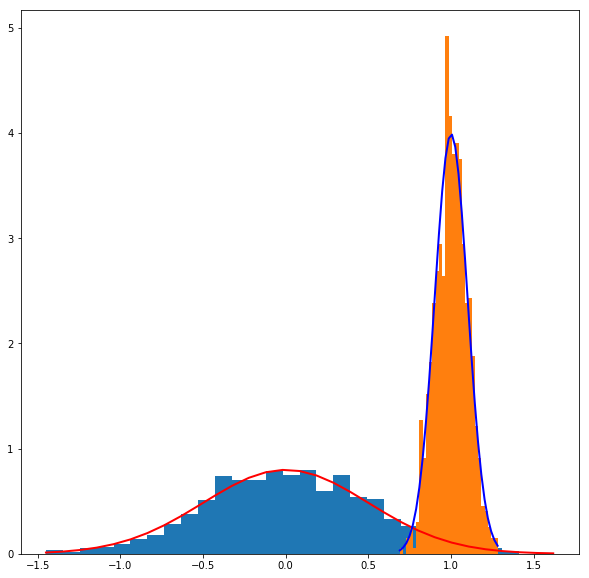

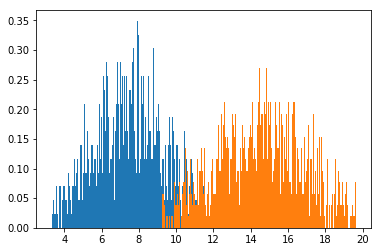

In [98]:
plt.figure(figsize=(10,10))

count, bins, ignored = plt.hist(gaussian0, 30, normed=True) 
plt.plot(bins, 1/(var0 * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu0)**2 / (2 * var0**2) ), linewidth=2, color='r') 

count, bins, ignored = plt.hist(gaussian1, 30, normed=True) 
plt.plot(bins, 1/(var1 * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu1)**2 / (2 * var1**2) ), linewidth=2, color='b') 

plt.show()

h = plt.hist(triangular0, bins=200, normed=True) 
h = plt.hist(triangular1, bins=200, normed=True)

plt.show()

<IPython.core.display.Javascript object>


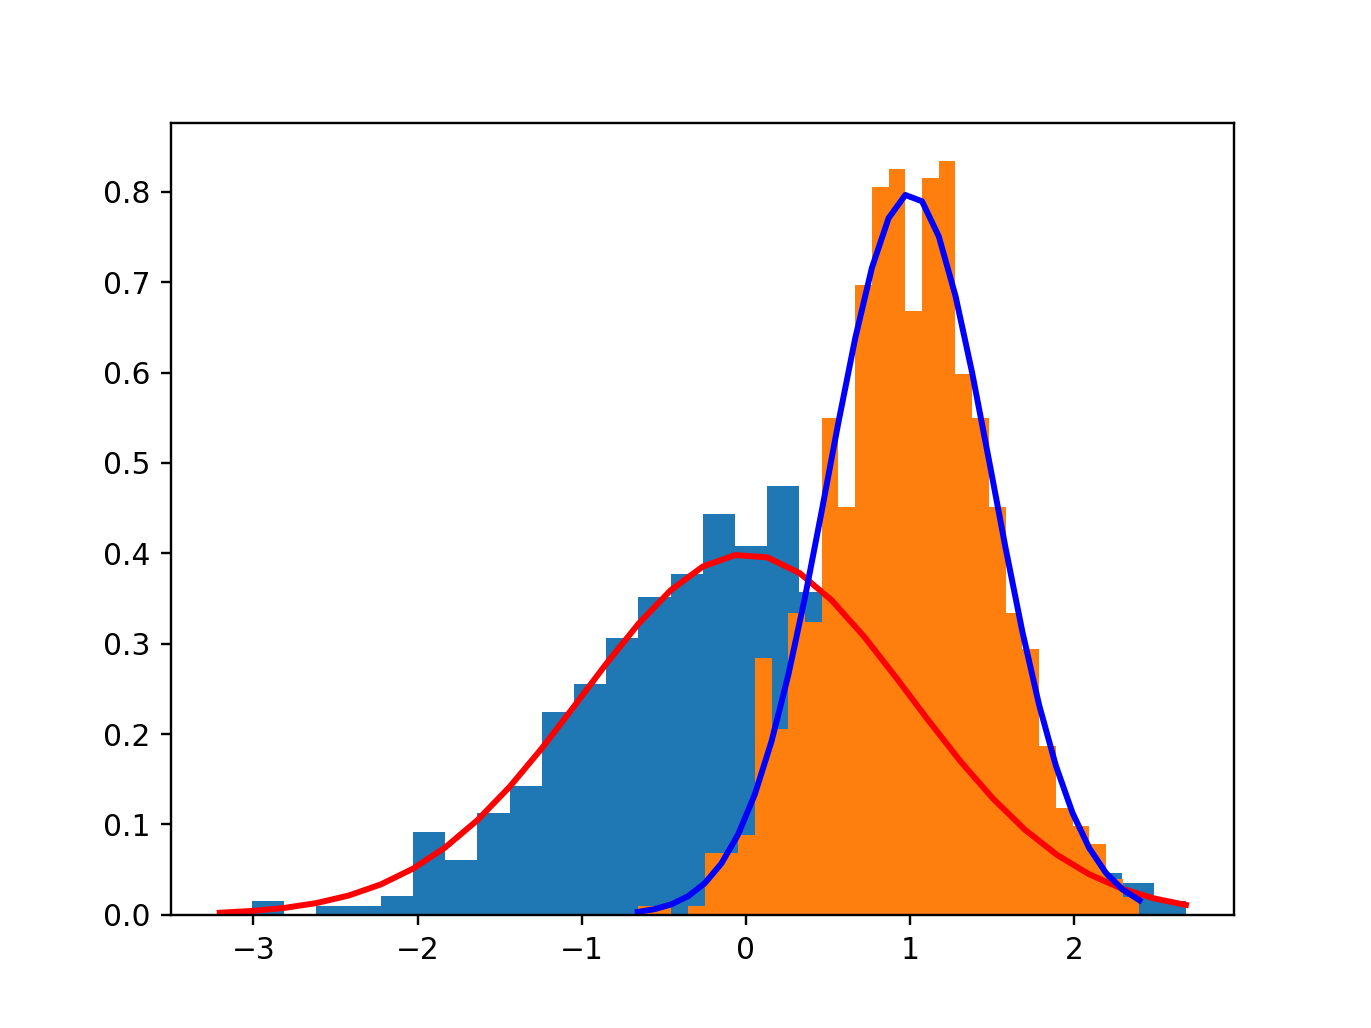

<IPython.core.display.Javascript object>


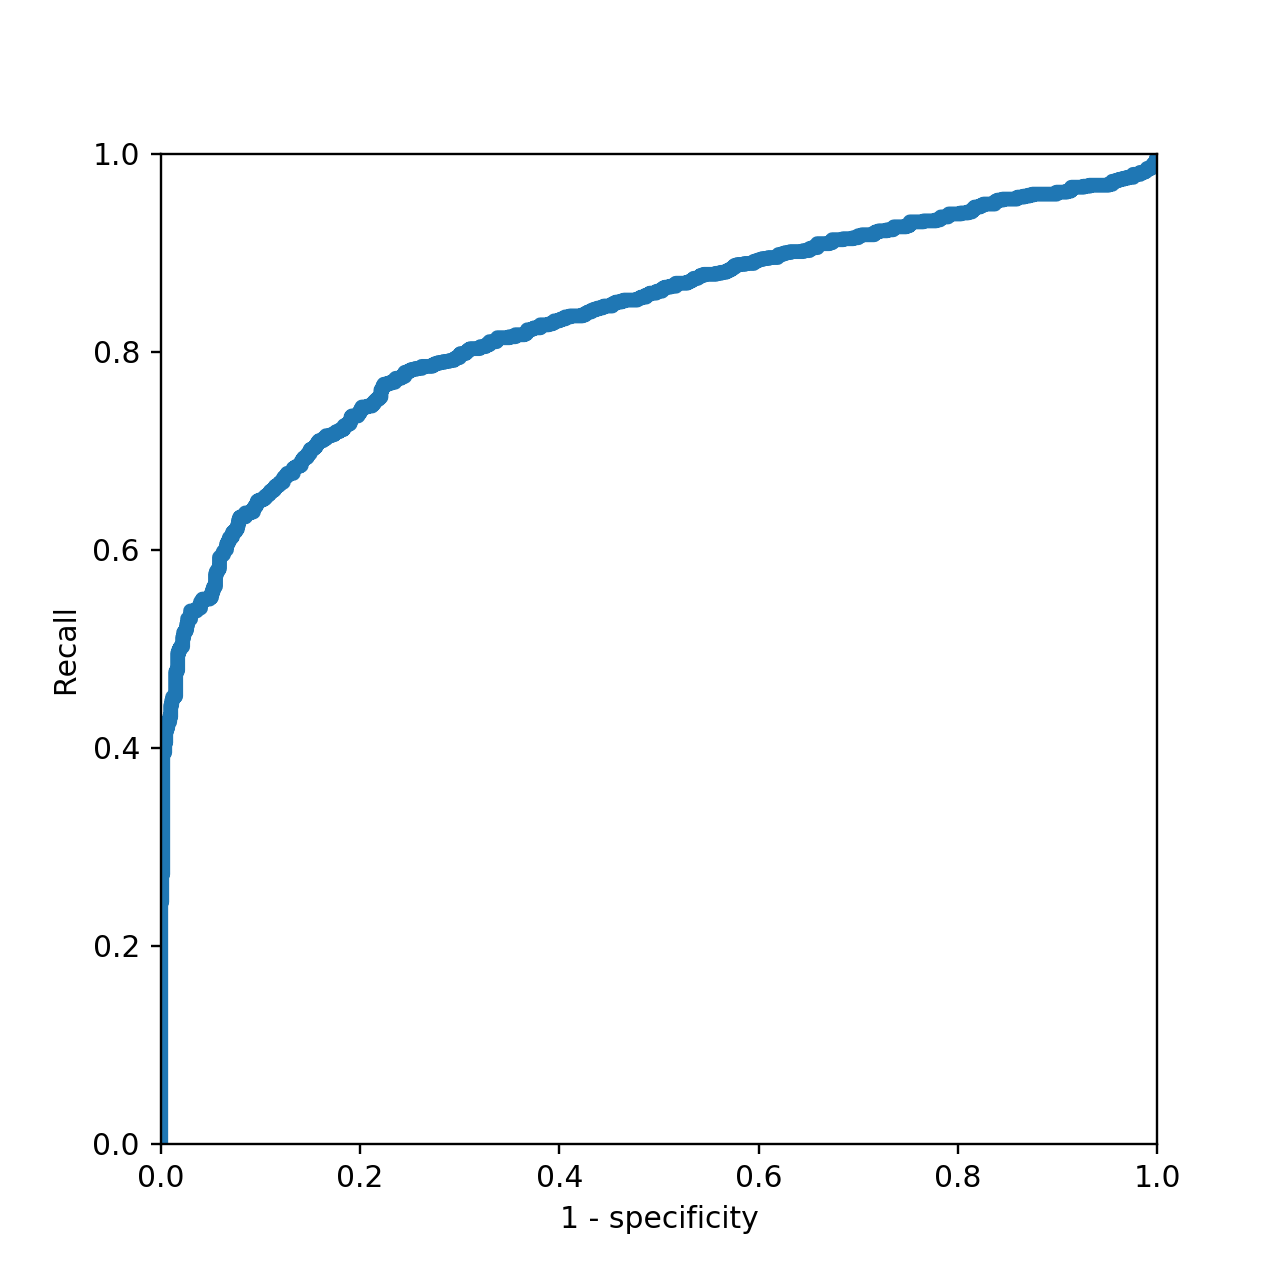